# Проект для «Викишоп» с BERT

![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Wikitext-wiki_markup-wikipedia.png/640px-Wikitext-wiki_markup-wikipedia.png 'MediaWiki')

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загрузим и познакомимся с имеющимися данными.

In [ ]:
! gdown 1Z6nB4Wz_PR4vXVda9L0YRf4xoIBG4SEj

Downloading...
From: https://drive.google.com/uc?id=1Z6nB4Wz_PR4vXVda9L0YRf4xoIBG4SEj
To: /content/toxic_comments.csv
100% 65.0M/65.0M [00:00<00:00, 161MB/s]


In [ ]:
! pip install optuna --quiet
! pip install fastai --quiet
! pip install transformers --quiet

     |████████████████████████████████| 348 kB 8.1 MB/s 
     |████████████████████████████████| 209 kB 64.9 MB/s 
     |████████████████████████████████| 81 kB 11.4 MB/s 
     |████████████████████████████████| 78 kB 9.3 MB/s 
     |████████████████████████████████| 147 kB 70.3 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 112 kB 62.9 MB/s 
     |████████████████████████████████| 4.7 MB 6.3 MB/s 
     |████████████████████████████████| 120 kB 27.1 MB/s 
     |████████████████████████████████| 6.6 MB 55.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.dummy import DummyClassifier

from fastai.text.all import TextDataLoaders
from fastai.text.all import text_classifier_learner
from fastai.text.all import AWD_LSTM

import optuna

import spacy

from transformers import pipeline

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (10, 7)})

In [ ]:
try:
    df = pd.read_csv('/content/toxic_comments.csv', index_col=0)
except:
    print('Возникла проблема с загрузкой данных')

In [ ]:
df.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_ar...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
toxic,159292.0,0.101612,0.302139,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

В нашем распоряжении файл с почти 160 тысячами комментариев. Пропусков данных нет, явных дупилкатов данных нет. 

Посмотрим на баланс классов.

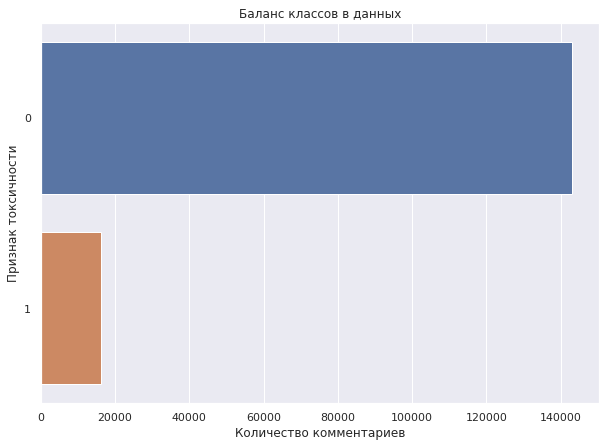

In [ ]:
sns.countplot(data=df, y='toxic')\
.set(title='Баланс классов в данных',
     xlabel='Количество комментариев',
     ylabel='Признак токсичности');

Видно, что комментариев, с признаком токсичности 1, довольно мало — классы не сбалансированы.

### Предварительные выводы

Мы загрузили данные и немного познакомились с ними. В нашем распоряжении файл с почти 16 тысячами комментариев. Пропусков данных нет, явных дупилкатов данных нет. 

Классы не сбалансированы, данных без признака токсичности сильно больше, что надо будет учитывать при обучении моделей машинного обучения.

## Обучение

Разделим наши данные на обучающую и тестовую выборки.

Прежде чем строить модель нам нужно закодировать комментарии таким образом, чтобы их было удобно обрабатывать. 

Будем создавать признаки методом *TF-IDF*. Подготовим список стоп-слов для английского языка.

In [ ]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Проведём лемматизацию текста. Этот этап хорошо бы перенести в *pipeline*, но тогда обучение будет занимать очень много времени. 

In [ ]:
X = df['text']
y = df['toxic']

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def lemmatize(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

In [ ]:
X_lemm = X.apply(lemmatize)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_lemm, y, test_size=.2, 
                                                    stratify=y,
                                                    random_state=42)

### Логистическая регрессия, опорные вектора, гребневая регрессия

Для аккуратности воспользуюемся *pipeline*-ами из библиотеки *sklearn*. Для предсказания воспользуемся логистической регрессией и методом опорных векторов.

In [ ]:
pipeline_lr = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words=stops)),
        ('logreg', LogisticRegression(random_state=42, class_weight='balanced'))
    ]
)

In [ ]:
pipeline_svc = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words=stops)),
        ('svc', LinearSVC(random_state=42, class_weight='balanced'))
    ]
)

In [ ]:
pipeline_rc = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words=stops)),
        ('lgbm', RidgeClassifier(random_state=42, class_weight='balanced'))
    ]
)

In [ ]:
%%time
logreg_scores = cross_val_score(pipeline_lr, X_train, y_train, n_jobs=-1, 
                                cv=10, scoring='roc_auc')

CPU times: user 2.62 s, sys: 527 ms, total: 3.14 s
Wall time: 1min 46s


In [ ]:
%%time
svc_scores = cross_val_score(pipeline_svc, X_train, y_train, n_jobs=-1, 
                             cv=10, scoring='roc_auc')

CPU times: user 2.28 s, sys: 248 ms, total: 2.53 s
Wall time: 1min 28s


In [ ]:
%%time
rc_scores = cross_val_score(pipeline_rc, X_train, y_train, 
                            n_jobs=-1, cv=10, scoring='roc_auc')

CPU times: user 2.28 s, sys: 262 ms, total: 2.54 s
Wall time: 1min 16s


In [ ]:
scores = pd.DataFrame({'Логистическая регрессия': logreg_scores,
                       'SVC': svc_scores,
                       'Гребневый классификатор': rc_scores})

In [ ]:
scores.mean()

Логистическая регрессия    0.971713
SVC                        0.966510
Гребневый классификатор    0.927028
dtype: float64

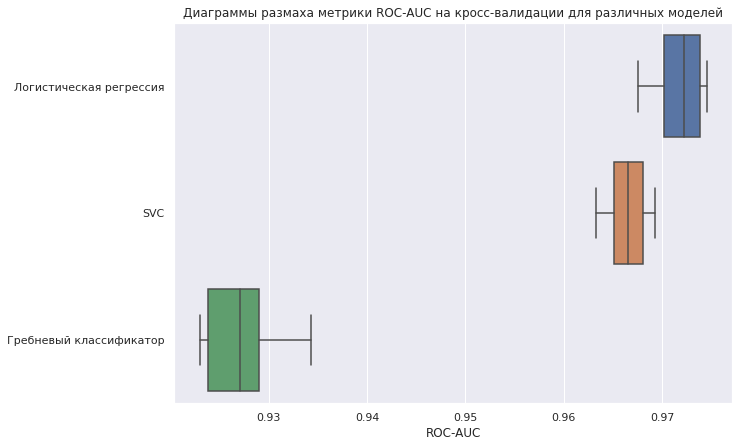

In [ ]:
sns.boxplot(data=scores, orient='h')\
.set(title='Диаграммы размаха метрики ROC-AUC на кросс-валидации для различных моделей',
     xlabel='ROC-AUC');

Для наших данных на кросс-валидации лучше всего показала себя модель на основе логистической регресси. Подберём её гипер-параметры.

In [ ]:
def objective(trial):
    C = trial.suggest_float('C', 0.01, 1)
    max_n = trial.suggest_int('max_n', 1, 3)
    pipeline_lr = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words=stops,
                                    ngram_range=(1, max_n))),
        ('logreg', LogisticRegression(random_state=42, 
                                        C=C,
                                        class_weight='balanced'))
    ]
    )
    pipeline_lr.fit(X_train, y_train)
    scores = cross_val_score(pipeline_lr, X_train, y_train, 
                            n_jobs=-1, scoring='f1')
    return scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=10)

[I 2022-09-05 17:45:18,323] A new study created in memory with name: no-name-4c30a3c3-fcbf-4bc4-8a18-4d2eca668a5a
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-09-05 17:55:45,706] Trial 0 finished with value: 0.7107119156444058 and parameters: {'C': 0.3807947176588889, 'max_n': 3}. Best is trial 0 with value: 0.7107119156444058.
[I 2022-09-05 18:00:45,119] Trial 1 finished with value: 0.741140143605154 and parameters: {'C': 0.7346740023932911, 'max_n': 2}. Best is trial 1 with value: 0.741140143605154.
[I 2022-09-05 18:01:32,642] Trial 2 finished with value: 0.717770192722641 and parameters: {'C': 0.16445845403801215, 'max_n': 1}. Best is trial 1 with value: 0.741140143605154.
[I 2022-09-05 18:09:14,807] Trial 3 finished with value: 0.6857578360956732 

In [ ]:
best_params = study.best_params

In [ ]:
best_params

{'C': 0.8341182143924175, 'max_n': 1}

In [ ]:
pipeline_lr = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words=stops,
                                  ngram_range=(1, best_params['max_n']))),
        ('logreg', LogisticRegression(random_state=42, n_jobs=-1, 
                                      class_weight='balanced',
                                      C=best_params['C']))
    ]
)

Мы подобрали гипер-параметры. Теперь выберем порог классификации с учётом [дисбаланса](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/).

In [ ]:
# сделаем валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  stratify=y_train,
                                                  random_state=42)

In [ ]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('logreg',
                 LogisticRegression(C=0.8341182143924175,
                                    class_weight='balanced', n_jobs=-1,
                                    random_state=42))])

Посмотрим на ROC-кривую нашей модели.

In [ ]:
y_score = pipeline_lr.decision_function(X_val)

In [ ]:
fprs, tprs, thrs = roc_curve(y_val, y_score)

In [ ]:
roc = pd.DataFrame({'FPR': fprs,
                    'TPR': tprs,
                    'threshold': thrs})

In [ ]:
roc_auc = auc(fprs, tprs)

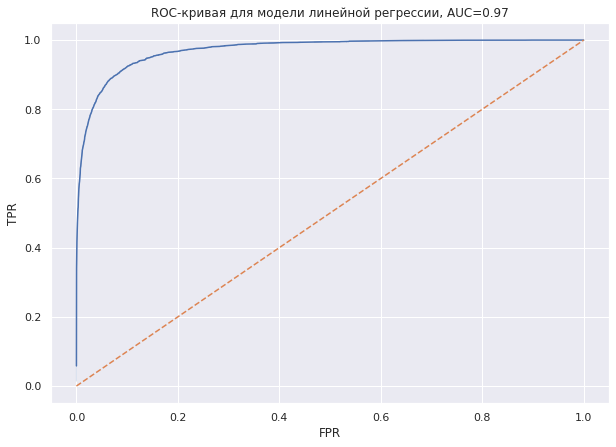

In [ ]:
sns.lineplot(data=roc, x='FPR', y='TPR')\
.set(title=f'ROC-кривая для модели линейной регрессии, AUC={round(roc_auc, 2)}')
plt.plot([0, 1], [0, 1], linestyle="--")
plt.show()

Попробуем подобрать оптимальный порог.

In [ ]:
predict_proba = pipeline_lr.predict_proba(X_val)

In [ ]:
predict_proba = predict_proba[:, 1]

In [ ]:
def to_labels(predict_proba, threshold):
	return (predict_proba >= threshold).astype('int')

In [ ]:
scores = [f1_score(y_val, to_labels(predict_proba, t)) for t in predict_proba]

In [ ]:
ix = np.argmax(scores)

In [ ]:
test_predict_proba = pipeline_lr.predict_proba(X_test)

In [ ]:
f1_score(y_test, to_labels(test_predict_proba[:, 1], predict_proba[ix]))

0.7814797434694197

Для линейной регрессии удалось довести метрику *F1* до значения 0.78. Посмотрим, что получится при применении нейросетей.

### Нейросети

#### fast.ai

Попробуем применить библиотеку [*fast.ai*](https://docs.fast.ai/38_tutorial.text.html).

In [ ]:
X = df['text']
y = df['toxic']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, 
                                                    stratify=y,
                                                    random_state=42)

In [ ]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [ ]:
dls_clas = TextDataLoaders.from_df(df=train, seed=42, bs=32)

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5)

In [ ]:
learn.fine_tune(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.230907,0.185276,05:10


epoch,train_loss,valid_loss,time
0,0.137266,0.105559,10:34
1,0.115941,0.104989,10:30
2,0.093039,0.096677,10:40
3,0.062775,0.093944,10:35
4,0.056738,0.101600,10:30


In [ ]:
dl = learn.dls.test_dl(test)

In [ ]:
preds, _ = learn.get_preds(dl=dl)

In [ ]:
f1_score(y_test, preds.argmax(axis=1))

0.8231116849580374

Библиотека *fast.ai* подтянула метрику *F1* до значения 0.82. Неплохо.

#### BERT

Применим нейросеть BERT. Попробуем сделать предсказания с помощью уже обученной модели от [HuggingFace](huggingface.co). Обучение модели на тренировочных данных заняло бы слишком много времени.

In [ ]:
X = df['text']
y = df['toxic']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, 
                                                    stratify=y,
                                                    random_state=42)

In [ ]:
classifier = pipeline("sentiment-analysis", 
                      model='unitary/toxic-bert',
                      device=0)

In [ ]:
%%time
preds = classifier(X_test.to_list(), padding=True, 
                   max_length=512, truncation=True,
                   batch_size=32)

CPU times: user 15min 10s, sys: 38 s, total: 15min 48s
Wall time: 15min 50s


In [ ]:
def to_labels(predict_proba, threshold):
	return (predict_proba >= threshold).astype('int')

In [ ]:
y_pred_bert = to_labels(pd.DataFrame(preds)['score'], 0.5)

In [ ]:
f1_score(y_test, y_pred_bert)

0.9396605908233815

Модель *BERT* дала очень высокое значение метрики *F1*=0.94. И нам даже не пришлось её обучать!

### Dummy classifier

Чтобы проверить наши модели на адекватность создадим «глупый» классификатор, который всегда отмечает комментарии как не токсичные и сравним его метрику с нашими моделями.

In [ ]:
dc = DummyClassifier(strategy='uniform', random_state=42)

In [ ]:
X = df['text']
y = df['toxic']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, 
                                                    stratify=y,
                                                    random_state=42)

In [ ]:
dc.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='uniform')

In [ ]:
y_pred_dc = dc.predict(X_test)

In [ ]:
f1_score(y_test, y_pred_dc)

0.17127359966621467

«Глупый» классификатор оказался хуже всех моделей, которые мы рассмотрели в нашем проекте, а значит все они прошли проверку на адекватность.

### Предварительные выводы

Мы попробовали решить задачу несколькими способами.

Для начала мы сравнили модели на основе логистической регрессии, метода опроных векторов и гребневой регрессии. Предварительно мы провели леммаизацию признаков с помощью библиотеки nltk. Модель линейной регресии показала наивысшее значение метрики *ROC-AUC*, поэтому мы отобрали её для дальнейшего обучения. После подобора гипер-параметров и выбора оптимального порога модель обеспечила значение метрики *F1*=0.78. 

Затем мы применили две модели на основе нейросетей. Для их использования нам понадобилось использовать видеокарты.

Модель на основе библиотеки *fast.ai* после обучения смогла классифицировать комментарии довольно точно, значение метрики *F1* составило 0.82.

Предобученная модель *BERT* из библиотеки *HuggingFace* делелала предсказания довольно долго, но в конце дотянула метрику *F1* до великолепного 0.94.

Сведём результаты моделей в единую таблицу.

| Item         | F1     | 
|--------------|-----------|
| Логистическая регрессия | 0.78      | 
| fast.ai (LSTM)      | 0.82  |
| HuggingFace (BERT)      | 0.94 |

Исходя из значения метрики *F1* мы можем рекомендовать заказчику нейросетевую модель *BERT*. Однако если заказчику важно ещё и время расчётов предсказаний, то можно рассмотреть возможность применения модели на основе библиотеки *fast.ai* (высокая скорость предсказаний и неплохая точность).

## Выводы

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Заказчику нужна модель со значением метрики качества *F1* не меньше 0.75.

Мы загрузили данные и немного познакомились с ними. В нашем распоряжении файл с почти 160 тысячами комментариев. Пропусков данных нет, явных дупилкатов данных нет. 

Классы не сбалансированы, данных без признака токсичности сильно больше.

Мы попробовали решить задачу несколькими способами.

Для начала мы сравнили модели на основе логистической регрессии, метода опроных векторов и гребневой регрессии. Предварительно мы провели леммаизацию признаков с помощью библиотеки *nltk*. Модель линейной регресии показала наивысшее значение метрики *ROC-AUC*, поэтому мы отобрали её для дальнейшего обучения. После подобора гипер-параметров и выбора оптимального порога модель обеспечила значение метрики *F1*=0.78.

Затем мы применили две модели на основе нейросетей. Для их использования нам понадобилось использовать видеокарты.

Модель на основе библиотеки *fast.ai* после обучения смогла классифицировать комментарии довольно точно, значение метрики *F1* составило 0.82.

Предобученная модель *BERT* из библиотеки *HuggingFace* делелала предсказания довольно долго, но в конце дотянула метрику *F1* до великолепного 0.94.

Сведём результаты моделей в единую таблицу.

| Item         | F1     | 
|--------------|-----------|
| Логистическая регрессия | 0.78      | 
| fast.ai (LSTM)      | 0.82  |
| HuggingFace (BERT)      | 0.94 |

Исходя из значения метрики *F1* мы можем рекомендовать заказчику нейросетевую модель *BERT*. Однако если заказчику важно ещё и время расчётов предсказаний, то можно рассмотреть возможность применения модели на основе библиотеки *fast.ai* (высокая скорость предсказаний и неплохая точность).